In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

tensor([[0.5888, 0.1281, 0.0366, 0.0326, 0.0256, 0.0251, 0.0221, 0.0213, 0.0174,
         0.0162, 0.0160, 0.0147, 0.0147, 0.0145, 0.0136, 0.0127]])


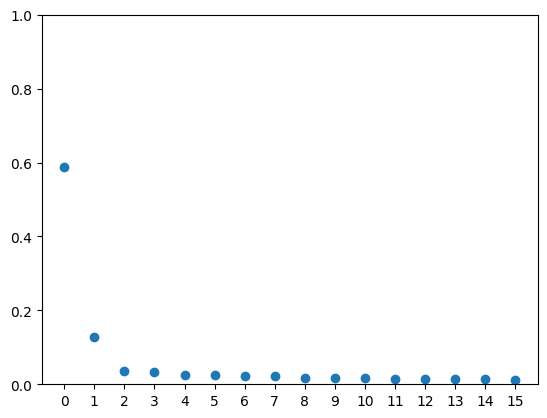

In [21]:
tensor_example = [[-183.6829, -214.1875, -239.2424, -241.5422, -246.3929, -246.7630,
         -249.3031, -250.0558, -254.1187, -255.5632, -255.8092, -257.4406,
         -257.4879, -257.7992, -259.0318, -260.4411]]
tensor_example = torch.tensor(tensor_example)

# plot the softmax output
import matplotlib.pyplot as plt
import numpy as np


def plot_softmax(tensor_example, knn_T=10):
    tensor_example = tensor_example / knn_T
    softmax = torch.nn.Softmax(dim=1)
    softmax_output = softmax(tensor_example)
    print(softmax_output)
    plt.plot(softmax_output.detach().numpy().flatten(), 'o')
    # shot the x axis as discrete values
    plt.xticks(np.arange(16))
    # plot the y from 0 to 1
    plt.ylim(0, 1)
    plt.show()

plot_softmax(tensor_example, 100)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
tokenizer(" positive")

{'input_ids': [3967], 'attention_mask': [1]}

In [2]:
'''
Choose sentiment from terrible or great.

Review: i would recommend big bad love only to winger fans who have missed her since 1995 's forget paris.
Sentiment: terrible
Review:  suspenseful enough for older kids but not . 
Sentiment: great

Review: the subtle strength of elling is that it never squandering touch with the reality of the grim situation . 
Sentiment:
'''
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf").to('cuda')

gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
gpt_model = AutoModelForCausalLM.from_pretrained("gpt2-xl").to('cuda')

# mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
# mistral_model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1").to('cuda')

In [11]:
gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
gpt_model = AutoModelForCausalLM.from_pretrained("gpt2-xl").to('cuda')

In [8]:
tokenizer(" negative")

{'input_ids': [1, 29871, 8178], 'attention_mask': [1, 1, 1]}

In [10]:
prompt = "Classify the sentiment of great and terrible.\n Review: i would recommend big bad love only to winger fans who have missed her since 1995 's forget paris.Sentiment: terrible\nReview:  suspenseful enough for older kids but not . \nSentiment: great\n"

input = "Review: the cd is not suitable for children . \nSentiment:"


prompt_ids = tokenizer.encode(prompt, return_tensors="pt")
input_ids = tokenizer.encode(input, return_tensors="pt")

input_ids = torch.cat([prompt_ids, input_ids[:, 1:]], dim=-1).to('cuda')

output = model(input_ids, return_dict=True).logits
print(output.shape)
output = output[:, len(input_ids[0]) - 1, :]
tokenizer.decode(torch.argmax(output, dim=-1).squeeze().tolist())

torch.Size([1, 85, 32000])


'terrible'

In [50]:
tokenizer("terrible")

{'input_ids': [1, 16403], 'attention_mask': [1, 1]}

In [24]:
prompt = """Classify the sentiment of positive and negative.
Review: i would recommend big bad love only to winger fans who have missed her since 1995 's forget paris . .
Sentiment: negative
Review: suspenseful enough for older kids but not .
Sentiment: positive
Review: another run-of-the-mill disney sequel intended for the home video market .
Sentiment: negative
Review: has never been smoother or more confident .
Sentiment: positive
Review: bad-movie .
Sentiment: negative
Review: sweetly .
Sentiment: positive
Review: like an extended dialogue exercise in retard 101 .
Sentiment: negative
Review: bouquet gives a performance that is masterly . .
Sentiment: positive"""

input1 = "Review: one of creepiest, scariest movies to come along in a long, long time, easily rivaling blair witch or the others. \nSentiment:"
input2 = "Review: good movie . \nSentiment:"

prompt_ids = gpt_tokenizer.encode(prompt, return_tensors="pt")
inputs1 = prompt + input1
inputs2 = prompt + input2

inputs = [inputs1, inputs2]
# inputs = [inputs1, inputs1]

gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
input_ids = gpt_tokenizer.batch_encode_plus(inputs, return_tensors="pt", padding=True, truncation=True)['input_ids'].to('cuda')

attention_mask = input_ids.ne(gpt_tokenizer.pad_token_id).float().to('cuda')
output = gpt_model(input_ids, attention_mask=attention_mask, return_dict=True).logits

last_non_pad_indices = torch.ne(input_ids, gpt_tokenizer.pad_token_id).sum(-1) - 1
print(last_non_pad_indices)
output = output[range(output.shape[0]), last_non_pad_indices, :]

gpt_tokenizer.batch_decode(torch.argmax(output, dim=-1).squeeze().tolist())

tensor([193, 167], device='cuda:0')


[' negative', ' positive']

In [33]:
prompt = "Classify the sentiment of positive and negative.\n Review: i would recommend big bad love only to winger fans who have missed her since 1995 's forget paris.Sentiment: negative\nReview:  suspenseful enough for older kids but not . \nSentiment: positive\n"

input = "Review: the cd is not suitable for children . \nSentiment:"
# try with the mistral tokenizer and model

prompt_ids = mistral_tokenizer.encode(prompt, return_tensors="pt")
input_ids = mistral_tokenizer.encode(input, return_tensors="pt")

input_ids = torch.cat([prompt_ids, input_ids[:, 1:]], dim=-1).to('cuda')

# add 10 padding tokens to the end of the input
input_ids = torch.cat([input_ids, torch.ones((1, 10)).long().to('cuda')], dim=-1)

attention_mask = input_ids != 1

output = mistral_model(input_ids, attention_mask=attention_mask, return_dict=True).logits
print(output.shape)
output = output[:, len(input_ids[0]) - 11, :]
mistral_tokenizer.decode(torch.argmax(output, dim=-1).squeeze().tolist())

torch.Size([1, 90, 32000])


'negative'

In [22]:
mistral_tokenizer("great")

{'input_ids': [1, 1598], 'attention_mask': [1, 1]}

In [51]:
gpt_tokenizer(" terrible")

{'input_ids': [353, 5547], 'attention_mask': [1, 1]}